In [16]:
%cd /Users/masha/Documents/visual-reasoning

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import timm
import kornia.geometry.transform as K

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 30
SUBDIVISION_CAP = 4

# DINOv3 Constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

/Users/masha/Documents/visual-reasoning


In [2]:
train_raw = np.load('./data/train_pairs.npy', allow_pickle=True)
test_raw = np.load('./data/test_balanced.npy', allow_pickle=True)

def prepare_data(raw_list, is_train=False):
    x0 = torch.tensor(np.stack([d['x0'] for d in raw_list])).float()
    x1 = torch.tensor(np.stack([d['x1'] for d in raw_list])).float()
    
    if x0.max() > 1.0:
        x0 = x0 / 255.0
        x1 = x1 / 255.0
        
    if x0.shape[1] == 1:
        x0 = x0.repeat(1, 3, 1, 1)
        x1 = x1.repeat(1, 3, 1, 1)
    
    normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    x0 = normalize(x0)
    x1 = normalize(x1)
    
    if is_train:
        y = torch.ones(len(raw_list))
    else:
        y = torch.tensor([1.0 if d.get('label') == 'same' else 0.0 for d in raw_list])
        
    return x0, x1, y

train_x0, train_x1, train_y = prepare_data(train_raw, is_train=True)
test_x0, test_x1, test_y = prepare_data(test_raw, is_train=False)

train_loader = DataLoader(TensorDataset(train_x0, train_x1, train_y), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(TensorDataset(test_x0, test_x1, test_y), batch_size=BATCH_SIZE)

print(f"Train Size: {len(train_loader.dataset)}")

Train Size: 153


In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class FlowReasoningModel(nn.Module):
    def __init__(self, backbone, backbone_dim=384, flow_dim=64):
        super().__init__()
        
        # Frozen Backbone
        self.backbone = backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        # Time Embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, flow_dim * 4),
            nn.GELU(),
            nn.Linear(flow_dim * 4, flow_dim * 4)
        )

        # Encoder (64x64)
        self.inc = DoubleConv(3, flow_dim)            
        self.down1 = Down(flow_dim, flow_dim * 2)     
        self.down2 = Down(flow_dim * 2, flow_dim * 4) # Bottleneck
        
        # Projection
        self.cond_proj = nn.Linear(backbone_dim, flow_dim * 4)

        # Decoder
        self.up1 = Up(flow_dim * 6, flow_dim * 2) 
        self.up2 = Up(flow_dim * 3, flow_dim)
        self.outc = nn.Conv2d(flow_dim, 3, kernel_size=1)

    def forward(self, x_t, t, x0_clean):
        with torch.no_grad():
            x0_high = F.interpolate(x0_clean, size=(224, 224), mode='bilinear', align_corners=False)
            feats = self.backbone.forward_features(x0_high)
            cls_token = feats[:, 0, :] 

        t_emb = self.time_mlp(t)             
        cond = self.cond_proj(cls_token)     
        global_cond = (t_emb + cond).unsqueeze(-1).unsqueeze(-1)

        x1 = self.inc(x_t)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        
        # Inject Reasoning
        x3 = x3 + global_cond
        
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        return self.outc(x)

dinov3 = timm.create_model("vit_small_patch16_dinov3", pretrained=True).to(DEVICE).eval()
model = FlowReasoningModel(backbone=dinov3).to(DEVICE)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

In [14]:
def get_best_alignment_angle(x0, x1):
    """
    Grid searches the best 2D rotation angle that aligns x0 to x1.
    Used to generate the 'Guide Path' for recursive training.
    """
    B = x0.shape[0]
    
    # Search 36 angles (0 to 360 degrees)
    angles = torch.linspace(0, 360, 36, device=DEVICE)
    
    best_mse = torch.full((B,), float('inf'), device=DEVICE)
    best_ang = torch.zeros((B,), device=DEVICE)
    
    for ang in angles:
        ang_batch = torch.full((B,), ang.item(), device=DEVICE)
        
        x_rot = K.rotate(x0, ang_batch)
        
        # Calculate Error vs Target x1
        mse = torch.mean((x_rot - x1)**2, dim=[1, 2, 3])
        
        mask = mse < best_mse
        best_mse[mask] = mse[mask]
        best_ang[mask] = ang_batch[mask]
        print(best_mse)
        
    return best_ang

Epoch [1/30] Loss: 13.43811
Epoch [2/30] Loss: 13.54879
Epoch [3/30] Loss: 13.43551
Epoch [4/30] Loss: 13.10790
Epoch [5/30] Loss: 13.29338
Epoch [6/30] Loss: 12.78208
Epoch [7/30] Loss: 12.28324
Epoch [8/30] Loss: 11.83692
Epoch [9/30] Loss: 12.11476
Epoch [10/30] Loss: 12.40693
Epoch [11/30] Loss: 12.60827
Epoch [12/30] Loss: 11.99906
Epoch [13/30] Loss: 11.74030
Epoch [14/30] Loss: 11.39758
Epoch [15/30] Loss: 11.54329
Epoch [16/30] Loss: 10.95655
Epoch [17/30] Loss: 11.54084
Epoch [18/30] Loss: 11.65129
Epoch [19/30] Loss: 10.96866
Epoch [20/30] Loss: 10.43386
Epoch [21/30] Loss: 10.15000
Epoch [22/30] Loss: 10.22642
Epoch [23/30] Loss: 9.99277
Epoch [24/30] Loss: 10.01193
Epoch [25/30] Loss: 9.26303
Epoch [26/30] Loss: 9.62178
Epoch [27/30] Loss: 9.79946
Epoch [28/30] Loss: 9.47005
Epoch [29/30] Loss: 9.30870
Epoch [30/30] Loss: 9.14617


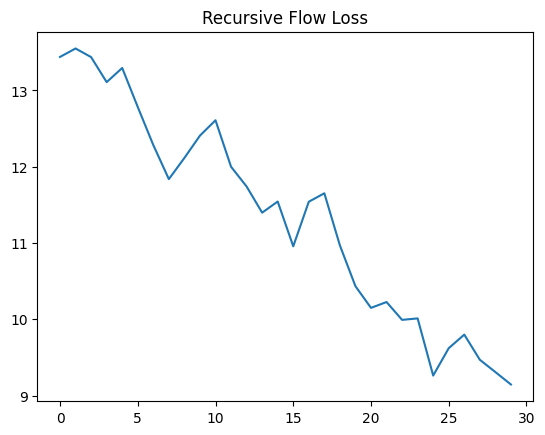

In [11]:
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for batch_idx, (x0, x1, _) in enumerate(train_loader):
        x0, x1 = x0.to(DEVICE), x1.to(DEVICE)
        B = x0.shape[0]
        
        # Find the global angle theta that maps start to end
        with torch.no_grad():
            theta_total = get_best_alignment_angle(x0, x1)
        
        # Pick a random segment k (0 to N-1)
        k = torch.randint(0, SUBDIVISION_CAP, (B,), device=DEVICE)
        
        seg_len = 1.0 / SUBDIVISION_CAP
        
        # Calculate Start/End percentages for this segment
        # e.g., Segment 1 is 0.25 -> 0.50
        t_start_global = k.float() * seg_len
        t_end_global   = (k.float() + 1) * seg_len
        
        # Convert to Angles
        ang_start = theta_total * t_start_global
        ang_end   = theta_total * t_end_global
        
        # Generate waypoints (fake data)
        with torch.no_grad():
            x_seg_start = K.rotate(x0, ang_start)
            x_seg_end   = K.rotate(x0, ang_end)
            
            # Optional: Anchor the final segment to the REAL x1
            # This helps fix perspective errors in the last step
            mask_last = (k == SUBDIVISION_CAP - 1)
            # x_seg_end[mask_last] = x1[mask_last] 
        
        # Train flow between the two waypoints
        # Sample local t (0 to 1 within this segment)
        t_local = torch.rand(B, 1, device=DEVICE)
        t_view = t_local.view(B, 1, 1, 1)
        
        # Interpolate Position
        x_t = (1 - t_view) * x_seg_start + t_view * x_seg_end
        
        # Target Velocity (Distance / Time)
        # Note: Since t_local is 0-1, v is just end - start
        target_v = x_seg_end - x_seg_start
        
        # The model needs to know the GLOBAL time 
        t_global = t_start_global.view(B, 1) + (t_local * seg_len)
        
        # Condition on x0 (Original Start)
        pred_v = model(x_t, t_global, x0)
        
        loss = F.mse_loss(pred_v, target_v)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.5f}")

plt.plot(train_losses)
plt.title("Recursive Flow Loss")
plt.show()

Generating Reasoning Trace...


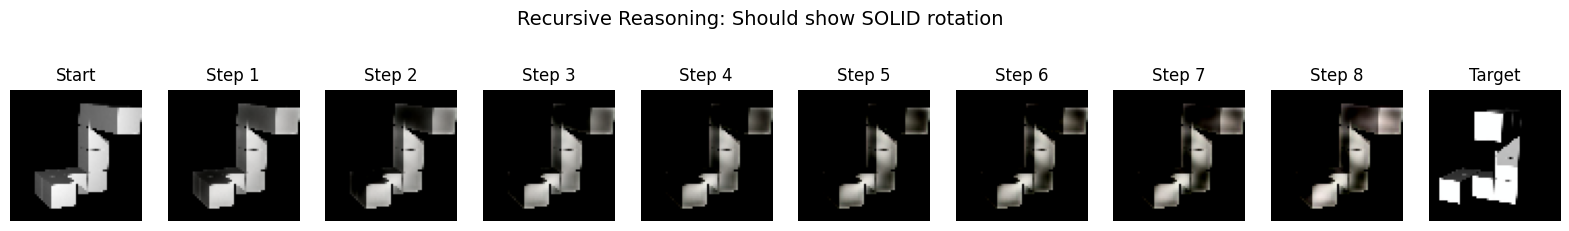

In [12]:
# ODE Solver for validation
@torch.no_grad()
def solve_flow(model, x_start, steps=10):
    model.eval()
    dt = 1.0 / steps
    curr = x_start.clone()
    trajectory = [curr.cpu()]
    
    for i in range(steps):
        t = torch.full((x_start.shape[0], 1), i / steps, device=DEVICE)
        v = model(curr, t, x_start)
        curr = curr + v * dt
        trajectory.append(curr.cpu())
        
    return trajectory

# Pick a sample
idx = 0
x0_vis = test_x0[idx:idx+1].to(DEVICE)
x1_vis = test_x1[idx:idx+1].to(DEVICE)

print("Generating Reasoning Trace...")
frames = solve_flow(model, x0_vis, steps=8)

# Plot
fig, axes = plt.subplots(1, 10, figsize=(20, 3))

# Start
def show(ax, t, title=""):
    img = t[0].permute(1, 2, 0).numpy()
    img = (img * IMAGENET_STD) + IMAGENET_MEAN # Denorm
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

show(axes[0], x0_vis.cpu(), "Start")

for i in range(8):
    show(axes[i+1], frames[i+1], f"Step {i+1}")

show(axes[9], x1_vis.cpu(), "Target")
plt.suptitle("Recursive Reasoning: Should show SOLID rotation", fontsize=14)
plt.show()

Checking Alignment Heuristic on Test Set...
tensor([11.7235, 15.9149, 20.0801,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 20.0801,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 20.0801,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 20.0801,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 20.0801,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 20.0801,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 20.0801,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 18.5865,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 15.5560,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 14.4787,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 14.4787,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 14.4787,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 14.4787,  7.8310, 13.3692], device='mps:0')
tensor([11.7235, 15.9149, 14.4787,  7.8310, 13

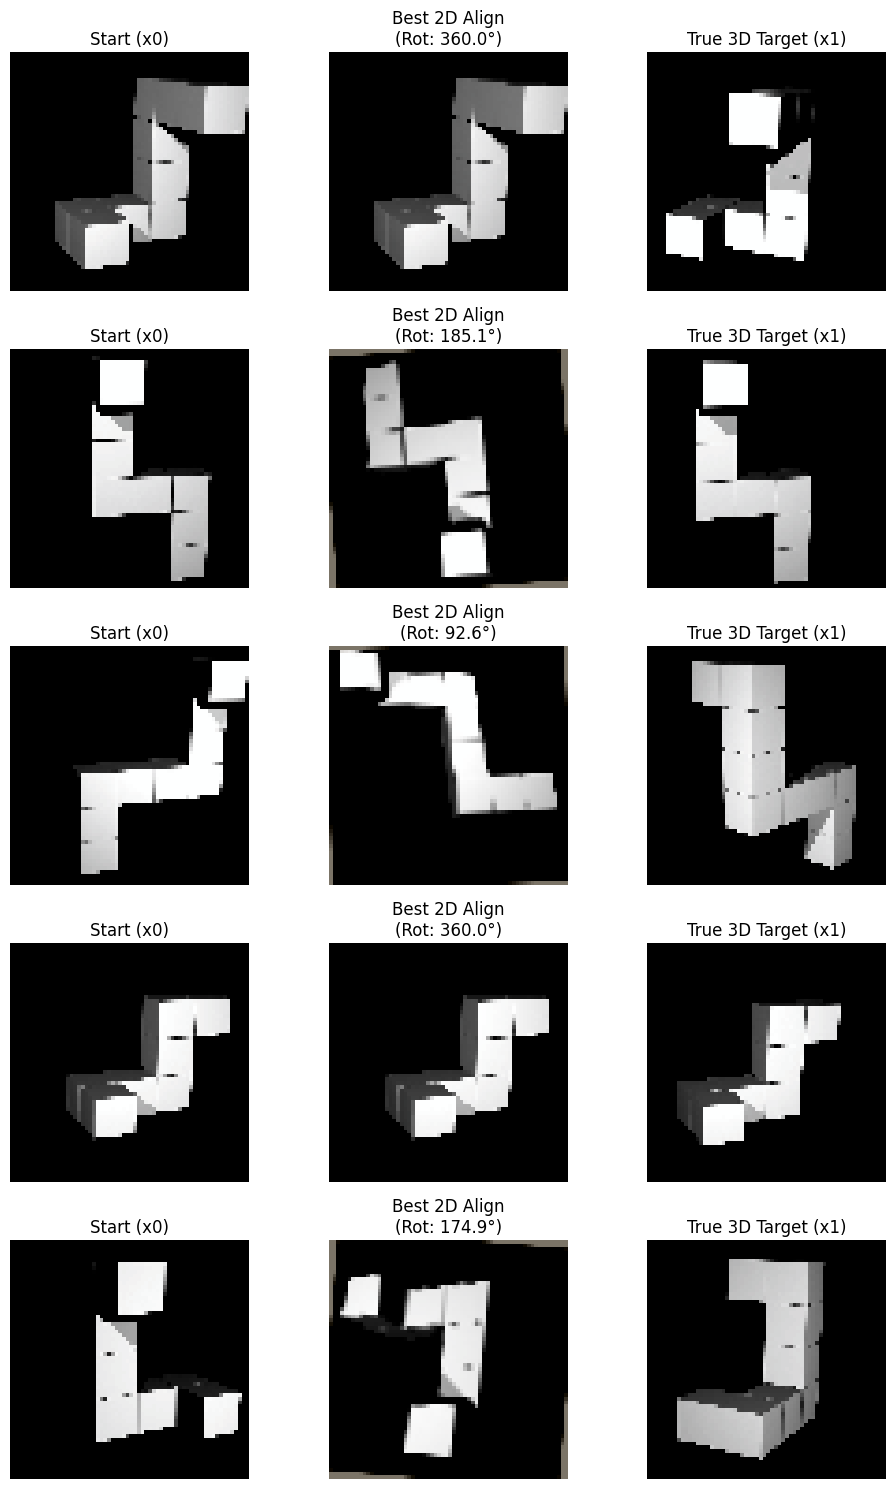

In [15]:
# --- VISUALIZATION HELPER ---
def visualize_alignment_heuristic(loader, num_samples=5):
    """
    Visualizes what the 'Best Alignment' function actually produces.
    Compares: Start -> Best 2D Rotation -> True 3D Target
    """
    # 1. Get a batch
    x0, x1, labels = next(iter(loader))
    x0, x1 = x0.to(DEVICE), x1.to(DEVICE)
    
    # Filter for 'Same' pairs only (labels=1)
    # We can't align different objects!
    mask = (labels == 1.0)
    x0 = x0[mask][:num_samples]
    x1 = x1[mask][:num_samples]
    
    if len(x0) == 0:
        print("No 'same' pairs found in this batch to visualize.")
        return

    # 2. Run the Heuristic
    with torch.no_grad():
        # Find best angle
        best_angles = get_best_alignment_angle(x0, x1)
        
        # Generate the aligned image
        x_aligned = K.rotate(x0, best_angles)
        
        # Calculate Error (MSE)
        mse = torch.mean((x_aligned - x1)**2, dim=[1, 2, 3])

    # 3. Plot
    fig, axes = plt.subplots(len(x0), 3, figsize=(10, 3 * len(x0)))
    if len(x0) == 1: axes = [axes] # Handle single row case

    # Helper to denormalize
    def denorm(t):
        img = t.cpu().permute(1, 2, 0).numpy()
        img = (img * IMAGENET_STD) + IMAGENET_MEAN
        return np.clip(img, 0, 1)

    print(f"{'Angle':<10} | {'MSE Error':<10} | {'Status'}")
    print("-" * 35)

    for i in range(len(x0)):
        # Metrics
        ang = best_angles[i].item()
        err = mse[i].item()
        status = "Good Match" if err < 0.5 else "Perspective Mismatch" # Arbitrary threshold
        print(f"{ang:>6.1f}°   | {err:>6.4f}     | {status}")

        # Draw
        ax_row = axes[i] if len(x0) > 1 else axes
        
        # Column 1: Start
        ax_row[0].imshow(denorm(x0[i]))
        ax_row[0].set_title("Start (x0)")
        ax_row[0].axis('off')
        
        # Column 2: Heuristic Result (What we train on)
        ax_row[1].imshow(denorm(x_aligned[i]))
        ax_row[1].set_title(f"Best 2D Align\n(Rot: {ang:.1f}°)")
        
        # Highlight borders based on error
        color = 'green' if err < 0.3 else 'orange'
        for spine in ax_row[1].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
        ax_row[1].axis('off')

        # Column 3: True Target
        ax_row[2].imshow(denorm(x1[i]))
        ax_row[2].set_title("True 3D Target (x1)")
        ax_row[2].axis('off')

    plt.tight_layout()
    plt.show()

# --- RUN IT ---
print("Checking Alignment Heuristic on Test Set...")
visualize_alignment_heuristic(test_loader, num_samples=5)